https://www.kaggle.com/code/sargisiskandaryan/fine-tune-t5-for-news-article-summarization

In [ ]:
!pip install evaluate rouge_score

In [ ]:
!pip install accelerate

In [ ]:
!pip install datasets

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### TODO Recording:

- Behind the scenes upload the BBCNewsSummary.zip file to a folder called bbc_dataset/ in MyDrive.
- Just show the uploaded zip file on Drive


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### TODO Recording:

* Open up the folder on the left and show that drive/MyDrive is mounted

In [ ]:
path_to_zip_file = "/content/drive/MyDrive/bbc_dataset/BBCNewsSummary.zip"

path_to_zip_file

'/content/drive/MyDrive/bbc_dataset/BBCNewsSummary.zip'

##### Unzips inside the folder dataset

In [ ]:
import zipfile

with zipfile.ZipFile(path_to_zip_file, "r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/bbc_dataset")

* Go to the bbc_dataset/ folder
* Show the subfolders
* Click through "News Articles" and show the categories
* Click through to one category and open up a single text file and show
* Click through "ummaries" and show the categories
* Click through to one category and open up a single text file and show



##### extract that takes a file path as input, extracts the category and file ID from the file path using a regular expression, then reads the content of the file and returns the category, file ID, and text content

In [ ]:
import re

def extract(filepath):
    pattern = r"(\w+)/(\d+)\.txt$"

    category, file_id = re.search(pattern, str(filepath)).groups()

    with open(filepath, "r", encoding = "unicode_escape") as f:
        text = f.read()
        return category, file_id, text

##### merges these DataFrames based on the "Category" and "ID" columns to create a combined DataFrame called news_summary_df

In [ ]:
import pandas as pd
from pathlib import Path

dataset_path = Path("/content/drive/MyDrive/bbc_dataset/BBC News Summary/")

articles_data = list(map(extract, dataset_path.glob("News Articles/*/*.txt")))
summaries_data = list(map(extract, dataset_path.glob("Summaries/*/*.txt")))

articles_df = pd.DataFrame(articles_data, columns = ("Category", "ID", "Article"))
summaries_df = pd.DataFrame(summaries_data, columns = ("Category", "ID", "Summary"))

news_summary_df = articles_df.merge(summaries_df, how = "inner", on = ("Category", "ID"))

news_summary_df.sample(10)

Category   ID                                            Article  \
0  entertainment  289  Musicians to tackle US red tape\n\nMusicians' ...   
1  entertainment  262  U2's desire to be number one\n\nU2, who have w...   
2  entertainment  276  Rocker Doherty in on-stage fight\n\nRock singe...   
3  entertainment  060  Snicket tops US box office chart\n\nThe film a...   
4  entertainment  074  Ocean's Twelve raids box office\n\nOcean's Twe...   

                                             Summary  
0  Nigel McCune from the Musicians' Union said Br...  
1  But they still want more.They have to want to ...  
2  Babyshambles, which he formed after his acrimo...  
3  A Series of Unfortunate Events also stars Scot...  
4  Ocean's Twelve, the crime caper sequel starrin...

In [ ]:
news_summary_df.shape

(2225, 4)

In [ ]:
news_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   ID        2225 non-null   object
 2   Article   2225 non-null   object
 3   Summary   2225 non-null   object
dtypes: object(4)
memory usage: 86.9+ KB


In [ ]:
news_summary_df.isnull().sum()

Category    0
ID          0
Article     0
Summary     0
dtype: int64

In [ ]:
news_summary_df[news_summary_df.duplicated()]

Empty DataFrame
Columns: [Category, ID, Article, Summary]
Index: []

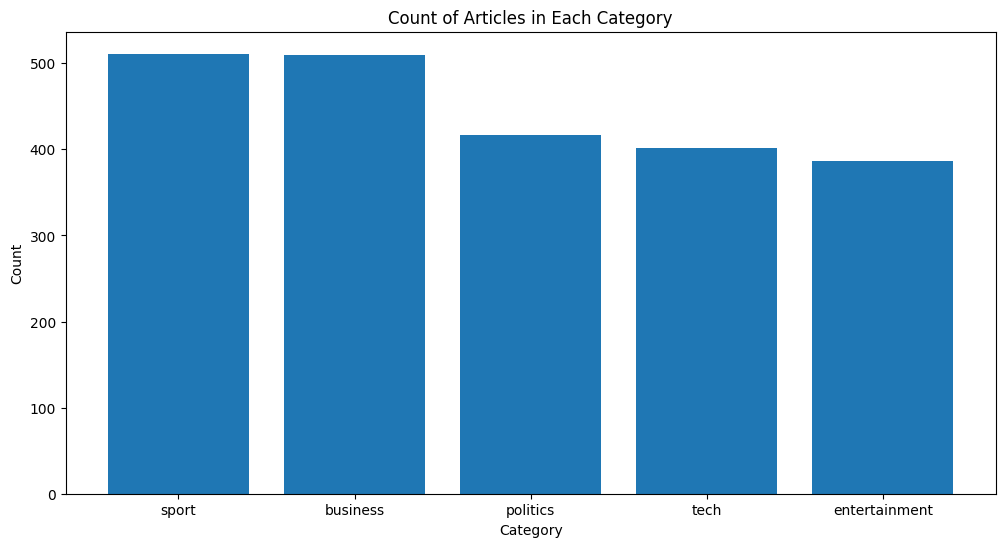

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.bar(news_summary_df['Category'].value_counts().index,
        news_summary_df['Category'].value_counts())

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Articles in Each Category')

plt.show()

In [ ]:
average_article_words = news_summary_df['Article'].apply(lambda x: len(str(x).split())).mean()

print("Average number of words in the 'Article' column:", round(average_article_words, 2))

Average number of words in the 'Article' column: 384.04


In [ ]:
average_summary_words = news_summary_df['Summary'].apply(lambda x: len(str(x).split())).mean()

print("Average number of words in the 'Summary' column:", round(average_summary_words, 2))

Average number of words in the 'Summary' column: 165.17


In [ ]:
news_summary_df['Article Length'] = news_summary_df['Article'].apply(lambda x: len(str(x).split()))
news_summary_df['Summary Length'] = news_summary_df['Summary'].apply(lambda x: len(str(x).split()))

news_summary_df.head(10)

Category   ID                                            Article  \
0  entertainment  289  Musicians to tackle US red tape\n\nMusicians' ...   
1  entertainment  262  U2's desire to be number one\n\nU2, who have w...   
2  entertainment  276  Rocker Doherty in on-stage fight\n\nRock singe...   
3  entertainment  060  Snicket tops US box office chart\n\nThe film a...   
4  entertainment  074  Ocean's Twelve raids box office\n\nOcean's Twe...   
5  entertainment  048  'Landmark movies' of 2004 hailed\n\nUS film pr...   
6  entertainment  114  Pete Doherty misses bail deadline\n\nSinger Pe...   
7  entertainment  100  Fockers retain film chart crown\n\nComedy Meet...   
8  entertainment  128  Top gig award for Scissor Sisters\n\nNew York ...   
9  entertainment  316  Johnny Depp: The acting outlaw\n\nJohnny Depp,...   

                                             Summary  Article Length  \
0  Nigel McCune from the Musicians' Union said Br...             378   
1  But they still want more.They have to want to ...             838   
2  Babyshambles, which he formed after his acrimo...             358   
3  A Series of Unfortunate Events also stars Scot...             176   
4  Ocean's Twelve, the crime caper sequel starrin...             251   
5  The Institute also cited the death of actor Ma...             333   
6  Mr Wass was also given a curfew and told to su...             252   
7  Meet the Fockers also broke the box office rec...             311   
8  New York band Scissor Sisters have won a gig o...             211   
9  He played a much more serious, sensitive role ...             525   

   Summary Length  
0             153  
1             376  
2             142  
3              69  
4             126  
5             127  
6             110  
7             135  
8              85  
9             189

In [ ]:
print(news_summary_df['Article Length'].describe())

count    2225.000000
mean      384.040449
std       238.174497
min        89.000000
25%       246.000000
50%       332.000000
75%       471.000000
max      4432.000000
Name: Article Length, dtype: float64


In [ ]:
print(news_summary_df['Summary Length'].describe())

count    2225.000000
mean      165.166742
std       108.655971
min        38.000000
25%       103.000000
50%       142.000000
75%       202.000000
max      2073.000000
Name: Summary Length, dtype: float64


In [ ]:
category_means = news_summary_df.groupby('Category')[['Article Length', 'Summary Length']].mean()

category_means

Article Length  Summary Length
Category                                     
business           328.880392      139.929412
entertainment      330.621762      144.049223
politics           453.973621      195.709832
sport              329.262231      143.187867
tech               502.695761      213.837905

<Figure size 1200x600 with 0 Axes>

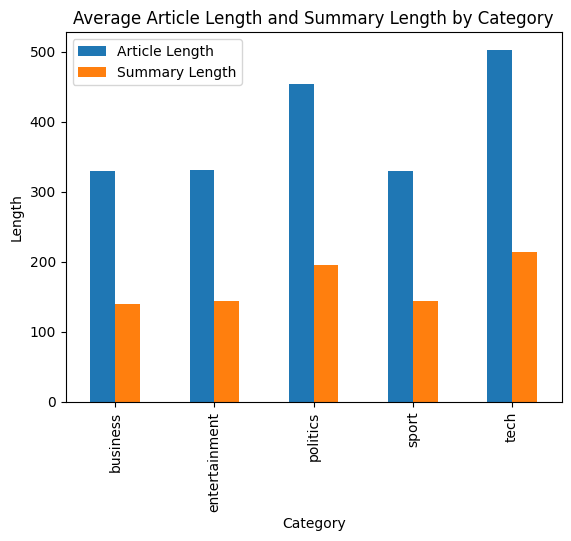

In [ ]:
plt.figure(figsize=(12, 6))

category_means.plot(kind='bar')

plt.xlabel('Category')
plt.ylabel('Length')

plt.title('Average Article Length and Summary Length by Category')
plt.show()

In [ ]:
from datasets import Dataset

news_summary_ds = Dataset.from_pandas(news_summary_df)

news_summary_ds

Dataset({
    features: ['Category', 'ID', 'Article', 'Summary', 'Article Length', 'Summary Length', '__index_level_0__'],
    num_rows: 2225
})

In [ ]:
news_summary_ds = news_summary_ds.remove_columns(['Category', '__index_level_0__', 'Article Length', 'Summary Length'])

news_summary_ds

Dataset({
    features: ['ID', 'Article', 'Summary'],
    num_rows: 2225
})

In [ ]:
news_summary_ds = news_summary_ds.train_test_split(test_size=0.2, seed=42)

news_summary_ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'Article', 'Summary'],
        num_rows: 1780
    })
    test: Dataset({
        features: ['ID', 'Article', 'Summary'],
        num_rows: 445
    })
})

In [ ]:
news_summary_ds.shape

{'train': (1780, 3), 'test': (445, 3)}

In [ ]:
news_summary_ds['train'].features

{'ID': Value(dtype='string', id=None),
 'Article': Value(dtype='string', id=None),
 'Summary': Value(dtype='string', id=None)}

##### cleaning the article and summary sentances

In [ ]:
def clean_txt(example):
    for txt in ["Article", "Summary"]:
       example[txt]  = example[txt].lower()
       example[txt]  = example[txt].replace("\\", "")
       example[txt]  = example[txt].replace("/", "")
       example[txt]  = example[txt].replace("\n", "")
       example[txt]  = example[txt].replace("``", "")
       example[txt]  = example[txt].replace('"', '')
       example[txt]  = example[txt].replace("--", "")

    return example

In [ ]:
news_summary_ds = news_summary_ds.map(clean_txt)

news_summary_ds

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'Article', 'Summary'],
        num_rows: 1780
    })
    test: Dataset({
        features: ['ID', 'Article', 'Summary'],
        num_rows: 445
    })
})

In [ ]:
EXAMPLE_TEXT_INDEX = 34

example_text = news_summary_ds["test"]["Article"][EXAMPLE_TEXT_INDEX]

example_text

'Labour\'s election love-in\n\nPeace and love have been in short supply in the Labour party in recent days.\n\nIf press reports are to be believed, Alan Milburn and Gordon Brown have been at each other\'s throats over the contents of Labour\'s next election manifesto. But the pair were all smiles on Tuesday morning, as they joined John Prescott to unveil Labour\'s latest poster campaign. The event - at Old Billingsgate Fish Market on the banks of the Thames - was a carefully choreographed show of unity. And the surest sign yet that we are heading for a general election in the next few months. It was also one of the most bizarre photo opportunities of recent years.\n\nThe first inkling something slightly odd was afoot was when - in place of the soft rock music normally chosen for such occasions - Labour\'s speakers crackled to life with the sound of Booker T and the MGs. Then a VW camper van trundled into view, decked out in that most mind-bending of psychedelic messages - "lowest mortg

https://huggingface.co/t5-small

In [ ]:
MODEL_NAME = "t5-small"

MODEL_NAME

't5-small'

### Without training

In [ ]:
from transformers import pipeline

prefix = "summarize: "

summarizer = pipeline("summarization", model = MODEL_NAME)

summary_txt = summarizer(prefix + example_text)

summary_txt

Token indices sequence length is longer than the specified maximum sequence length for this model (789 > 512). Running this sequence through the model will result in indexing errors


[{'summary_text': "labour's election love-in peace and love have been in short supply in recent days . but the pair were all smiles as they joined John Prescott to unveil the party's poster campaign . sadly, it wasn't the cabinet who raided the dressing-up box ."}]

In [ ]:
summarizer = pipeline("summarization", model = MODEL_NAME, truncation = True)

summary_txt = summarizer(prefix + example_text)

summary_txt

[{'summary_text': "labour's election love-in peace and love has been in short supply in recent days . the pair joined John Prescott to unveil the latest poster campaign . sadly, it wasn't the cabinet who raided the dressing-up box ."}]

In [ ]:
ref_txt = news_summary_ds["test"]["Summary"][EXAMPLE_TEXT_INDEX]

ref_txt

'The event may have been designed to highlight Labour\'s economic success under Mr Brown, but there was little doubt who was in charge.But it was Mr Milburn who took centre stage, speaking of the "positive campaign" the party hoped to stage in the "coming weeks and months".And, more specifically, to demonstrate the "central role" Mr Brown will play in the election campaign, despite being sidelined as campaign chief in favour of Mr Milburn.But it was the former health secretary\'s final gesture, placing an arm on Mr Brown\'s back as they walked away from the microphones, which was perhaps the most telling.There was much forced smiling for the cameras, but only Mr Prescott, who revels in such occasions, seemed to be truly enjoying himself.The event was carefully stage-managed to underline Cabinet unity.It was left to Mr Prescott to pay glowing tribute to the chancellor\'s record and, in a final flourish, to produce his famous pledge card, from 1997, claiming Labour has met all of its pro

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

rouge

EvaluationModule(name: "rouge", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id=None)}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLsum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/

In [ ]:
reference = "the shipwreck was discovered near the bay and everyone was relieved"

ex_1 = "the massive shipwreck was found near the stormy bay and everyone was astounded"

ex_2 = "the ancient artifact was found near the river and made everyone nostalgic"

Comparing with the same text will give you a ROUGE score of 1

In [ ]:
results = rouge.compute(predictions = [reference], references = [reference])

results

{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0, 'rougeLsum': 1.0}

##### ex_1 is more similar to reference than ex_2

In [ ]:
results = rouge.compute(predictions = [ex_1], references = [reference])

results

{'rouge1': 0.7500000000000001,
 'rouge2': 0.45454545454545453,
 'rougeL': 0.7500000000000001,
 'rougeLsum': 0.7500000000000001}

In [ ]:
results = rouge.compute(predictions = [ex_2], references = [reference])

results

{'rouge1': 0.5217391304347826,
 'rouge2': 0.09523809523809525,
 'rougeL': 0.5217391304347826,
 'rougeLsum': 0.5217391304347826}

### Coming back to our predicted summary

In [ ]:
summary_txt[0]["summary_text"]

"labour's election love-in peace and love has been in short supply in recent days . the pair joined John Prescott to unveil the latest poster campaign . sadly, it wasn't the cabinet who raided the dressing-up box ."

In [ ]:
result = rouge.compute(predictions = [summary_txt[0]["summary_text"]],
                       references = [ref_txt],
                       use_stemmer = True)
result

{'rouge1': 0.17508417508417506,
 'rouge2': 0.05423728813559322,
 'rougeL': 0.12121212121212122,
 'rougeLsum': 0.12121212121212122}

##### All article texts and summaries are defined in a list

In [ ]:
article_texts = news_summary_ds["test"]["Article"]

article_summaries = news_summary_ds["test"]["Summary"]

##### processes article texts from the "test" set adds a prefix to each text and obtains corresponding candidate summaries using the summarizer

In [ ]:
from tqdm import tqdm

candidate_summaries = []

prefix = "summarize: "

for i, text in enumerate(tqdm(article_texts[:50])):

    candidate = summarizer(prefix + text)

    candidate_summaries.append(candidate[0]["summary_text"])

100%|██████████| 50/50 [03:03<00:00,  3.66s/it]


##### ROUGE scores for the generated candidate summaries candidate_summaries against the reference summaries the aggregated scores are stored in result_agg and the unaggregated scores are stored in result_unagg

In [ ]:
result_agg = rouge.compute(predictions = candidate_summaries,
                           references = article_summaries[:50],
                           use_stemmer = True)
result_agg

{'rouge1': 0.3137213199372828,
 'rouge2': 0.20840241049188646,
 'rougeL': 0.23715315780019353,
 'rougeLsum': 0.23623731178391372}

In [ ]:
result_unagg = rouge.compute(predictions = candidate_summaries,
                             references = article_summaries[:50],
                             use_stemmer = True,
                             use_aggregator = False)
result_unagg

{'rouge1': [0.48407643312101917,
  0.3,
  0.11830985915492959,
  0.27058823529411763,
  0.3468208092485549,
  0.33043478260869563,
  0.06670942912123155,
  0.30303030303030304,
  0.25418060200668896,
  0.13296398891966757,
  0.3384615384615384,
  0.5454545454545454,
  0.2823529411764706,
  0.3333333333333333,
  0.31272727272727274,
  0.17326732673267328,
  0.1444866920152091,
  0.35593220338983056,
  0.30463576158940403,
  0.27777777777777773,
  0.32,
  0.39416058394160586,
  0.3804878048780488,
  0.2699386503067485,
  0.32558139534883723,
  0.2662337662337662,
  0.4761904761904762,
  0.19672131147540983,
  0.2983425414364641,
  0.35668789808917195,
  0.16463414634146342,
  0.12560386473429952,
  0.21978021978021975,
  0.4109589041095891,
  0.17508417508417506,
  0.3178294573643411,
  0.5,
  0.4176706827309236,
  0.3359375,
  0.4782608695652174,
  0.3025210084033613,
  0.38834951456310685,
  0.3170731707317074,
  0.427860696517413,
  0.44067796610169496,
  0.29523809523809524,
  0.2795

In [ ]:
import numpy as np

result_unagg_rsum = np.array(result_unagg["rouge2"])

best_summary_idx = np.argmax(result_unagg_rsum)
worst_summary_idx = np.argmin(result_unagg_rsum)

best_summary_idx, worst_summary_idx

(11, 31)

In [ ]:
import pandas as pd

act_vs_pred_summaries_df = pd.DataFrame(
    list(zip(candidate_summaries, article_summaries[:50])),
    columns = ["Predicted_Summaries", "Reference_summaries"]
)

act_vs_pred_summaries_df.sample(5)

Predicted_Summaries  \
24  the film tells the story of two adolescent boy...   
22  the campaign of legal action is thought to be ...   
29  GE's net profits were $5.37bn (£2.86bn) for th...   
15  mobile games have come a long way in a very sh...   
42  horror film Boogeyman took $19.5m (£14.9m) in ...   

                                  Reference_summaries  
24  Russian drama The Return (Vozvrashchenie) has ...  
22  The site is thought to have closed following a...  
29  GE said orders in the fourth quarter were 15% ...  
15  Even before Nokia's N-Gage game phone launched...  
42  This year, the top 12 films grossed around $91...

##### For the best rouge score, we can observe the predicted and reference summaries

In [ ]:
print("Actual Summary")
print(act_vs_pred_summaries_df._get_value(best_summary_idx, "Predicted_Summaries"))

print("Reference Summary")
print(act_vs_pred_summaries_df._get_value(best_summary_idx, "Reference_summaries"))

Actual Summary
the market for so-called "beer-like" drinks is set to grow 84% this year . asahi is predicting profits to rise 50% in 2005 as it launches a drink based on soybean peptides rather than malt .
Reference Summary
Asahi is predicting profits to rise 50% in 2005 as it launches a drink based on soybean peptides rather than malt.Japanese brewers are increasingly making money from beer-flavoured drinks rather than beer itself  Beer and spirits are heavily taxed in Japan, driving breweries to search for alternatives.Now, according to Asahi Breweries, the market for so-called "beer-like" drinks is set to grow 84% this year.But despite a record profit in 2004 of 30.6bn yen ($291m; Â£154m), up 31.8% on the previous year, Asahi is coming late to the market.


In [ ]:
print("Actual Summary")
print(act_vs_pred_summaries_df._get_value(worst_summary_idx, "Predicted_Summaries"))

print("Reference Summary")
print(act_vs_pred_summaries_df._get_value(worst_summary_idx, "Reference_summaries"))

Actual Summary
the 2005 Orange British Academy Film Awards are being held at the Odeon in Leicester Square . a host of stars are expected to attend the ceremony . the glittering ceremony will be broadcast on BBC One at 2010 GMT .
Reference Summary
British hope Imelda Staunton is one of the favourites to land the best actress award for her gritty role as a backstreet abortionist in the small-budget film.It is up against Eternal Sunshine of the Spotless Mind, Finding Neverland, The Motorcycle Diaries and British film Vera Drake, which has 11 nominations.Hollywood blockbuster The Aviator, starring DiCaprio, leads the field with 14 nominations, including best film.Other nominees in the best actress category include Charlize Theron for Monster, Ziyi Zhang for House of Flying Daggers and UK star Kate Winslet, who has two nods for her roles in Eternal Sunshine of the Spotless Mind and Finding Neverland.And British actor Clive Owen is hoping to repeat his Golden Globe success with a best suppo

### Start with fine-tuning

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
tokenizer(["in a shocking twist scientists unveil that dancing in the rain improves smartphone battery life by 50%"])

{'input_ids': [[16, 3, 9, 22565, 9135, 7004, 27080, 24, 10410, 16, 8, 3412, 1172, 7, 5626, 3322, 280, 57, 5743, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
tokens = tokenizer.tokenize("in a shocking twist scientists unveil that dancing in the rain improves smartphone battery life by 50%")

tokens

['▁in',
 '▁',
 'a',
 '▁shocking',
 '▁twist',
 '▁scientists',
 '▁unveil',
 '▁that',
 '▁dancing',
 '▁in',
 '▁the',
 '▁rain',
 '▁improve',
 's',
 '▁smartphone',
 '▁battery',
 '▁life',
 '▁by',
 '▁50%']

In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens)

ids

[16,
 3,
 9,
 22565,
 9135,
 7004,
 27080,
 24,
 10410,
 16,
 8,
 3412,
 1172,
 7,
 5626,
 3322,
 280,
 57,
 5743]

##### adds a prefix to each article tokenizes the inputs and labels using the tokenizer and ensures that the labels field in the model inputs corresponds to the tokenized summary

In [ ]:
prefix = "summarize: "

def preprocess_function(examples):

    inputs = [prefix + doc for doc in examples["Article"]]
    model_inputs = tokenizer(inputs, max_length = 1024, truncation = True)

    labels = tokenizer(text_target = examples["Summary"], max_length = 256, truncation = True)

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

In [ ]:
tokenized_news_summary_ds = news_summary_ds.map(preprocess_function, batched = True)

tokenized_news_summary_ds

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'Article', 'Summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1780
    })
    test: Dataset({
        features: ['ID', 'Article', 'Summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 445
    })
})

##### A data collator is commonly used during training to batch and preprocess sequences before they are fed into the mode

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer, model = MODEL_NAME)

##### evaluating sequence-to-sequence model performance takes the model predictions and labels from an evaluation step decodes them using the tokenizer and computes rouge scores between the decoded predictions and labels

##### Defining our training hyperparameters in Seq2SeqTrainingArguments. The only required parameter is output_dir which specifies where to save your model. We will push this model to the Hub by setting push_to_hub=True (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the Trainer will evaluate the ROUGE metric and save the training checkpoint. Passing the training arguments to Seq2SeqTrainer along with the model, dataset, tokenizer, data collator, and compute_metrics function. Calling train() to finetune your model.

In [ ]:
import tensorflow as tf
from transformers import create_optimizer, AdamWeightDecay
from transformers import TFAutoModelForSeq2SeqLM
from transformers.keras_callbacks import KerasMetricCallback
from transformers.keras_callbacks import PushToHubCallback

model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

model

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
optimizer = AdamWeightDecay(
    learning_rate = 2e-5,
    weight_decay_rate = 0.01
)

optimizer

In [ ]:
BATCH_SIZE = 8

BATCH_SIZE

8

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_news_summary_ds["train"],
    shuffle = True,
    batch_size = BATCH_SIZE,
    collate_fn = data_collator
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_news_summary_ds["test"],
    shuffle = False,
    batch_size = BATCH_SIZE,
    collate_fn = data_collator
)

In [ ]:
model.compile(optimizer = optimizer)

model.summary()

Model: "tft5_for_conditional_generation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### metric_callback: compute_metrics function to evaluate the model on a dataset tf_test_set and compute ROUGE scores

##### lr_reduce: callback for reducing the learning rate

- monitor: String, the name of the metric to monitor.
- factor: Float, the factor by which the learning rate will be reduced. new_lr = lr * factor.
- patience: Integer, number of epochs with no improvement after which learning rate will be reduced.
- verbose: Integer, 0: quiet, 1: update messages.
- mode: One of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.
- min_delta: Threshold for measuring the new optimum, to only focus on significant changes.
- cooldown: Number of epochs to wait before resuming normal operation after lr has been reduced.
- min_lr: Lower bound on the learning rate.

##### push_to_hub_callback: callback that pushes the trained model and tokenizer to the Hugging Face Model Hub

In [ ]:
lr_reduce_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 2,
    verbose = 0,
    mode = 'auto',
    min_delta = 0.0001,
    cooldown = 0,
    min_lr = 0
)

push_to_hub_callback = PushToHubCallback(
    output_dir = "summarization_fine_tune_bbc_summary",
    tokenizer = tokenizer
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/summarization_fine_tune_bbc_summary is already a clone of https://huggingface.co/jinxxx123/summarization_fine_tune_bbc_summary. Make sure you pull the latest changes with `repo.git_pull()`.


### TODO Recording:

* Now go to the model on HuggingFace from the profile section
* Click on "Model Card" show that it has been generated but is empty
* Click on "Files and Versions" and show - everything should be empty

In [ ]:
model.fit(
    x = tf_train_set,
    validation_data = tf_test_set,
    epochs = 4,
    callbacks = [lr_reduce_callback, push_to_hub_callback]
)

Epoch 1/4
222/222 [==============================] - 283s 1s/step - loss: 1.6536 - val_loss: 0.5957 - lr: 2.0000e-05
Epoch 2/4
222/222 [==============================] - 227s 1s/step - loss: 0.6788 - val_loss: 0.4060 - lr: 2.0000e-05
Epoch 3/4
222/222 [==============================] - 224s 1s/step - loss: 0.5284 - val_loss: 0.3573 - lr: 2.0000e-05
Epoch 4/4
222/222 [==============================] - 229s 1s/step - loss: 0.4693 - val_loss: 0.3329 - lr: 2.0000e-05


### TODO Recording:

* Now go to the model on HuggingFace from the profile section
* Click on "Model Card" show that it has been generated
* Click on "Files and Versions" and show

In [ ]:
example_text

'Labour\'s election love-in\n\nPeace and love have been in short supply in the Labour party in recent days.\n\nIf press reports are to be believed, Alan Milburn and Gordon Brown have been at each other\'s throats over the contents of Labour\'s next election manifesto. But the pair were all smiles on Tuesday morning, as they joined John Prescott to unveil Labour\'s latest poster campaign. The event - at Old Billingsgate Fish Market on the banks of the Thames - was a carefully choreographed show of unity. And the surest sign yet that we are heading for a general election in the next few months. It was also one of the most bizarre photo opportunities of recent years.\n\nThe first inkling something slightly odd was afoot was when - in place of the soft rock music normally chosen for such occasions - Labour\'s speakers crackled to life with the sound of Booker T and the MGs. Then a VW camper van trundled into view, decked out in that most mind-bending of psychedelic messages - "lowest mortg

In [ ]:
from transformers import pipeline

prefix = "summarize: "

summarizer = pipeline(
    "summarization",
    model = "loony-huggingface/summarization_fine_tune_bbc_summary",
    truncation = True
)

summary_txt = summarizer(prefix + example_text)

summary_txt

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/374M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at jinxxx123/summarization_fine_tune_bbc_summary.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

[{'summary_text': "The event - at Old Billingsgate Fish Market on the banks of the Thames - was a carefully choreographed show of unity.But the pair were all smiles on Tuesday morning, as they joined John Prescott to unveil Labour's latest poster campaign.But, sadly, it wasn't the Cabinet who had raided the dressing-up box - just six rather ill-at-ease looking Labour students."}]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("loony-huggingface/summarization_fine_tune_bbc_summary")

tokenizer

T5TokenizerFast(name_or_path='jinxxx123/summarization_fine_tune_bbc_summary', vocab_size=32100, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extr

In [ ]:
inputs = tokenizer(prefix + example_text, return_tensors = "tf", truncation = True).input_ids

inputs

<tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[21603,    10, 16117,    31,     7,  4356,   333,    18,    77,
        11128,    11,   333,    43,   118,    16,   710,  1899,    16,
            8, 16117,  1088,    16,  1100,   477,     5,   156,  2785,
         2279,    33,    12,    36,  6141,     6, 12453,  8573,  7223,
           11, 14626,  3899,    43,   118,    44,   284,   119,    31,
            7, 17703,     7,   147,     8, 10223,    13, 16117,    31,
            7,   416,  4356,  6571,    32,     5,   299,     8,  3116,
          130,    66,  3993,     7,    30,  2818,  1379,     6,    38,
           79,  3311,  1079, 10131, 10405,    12, 27080, 16117,    31,
            7,  1251, 10836,  2066,     5,    37,   605,     3,    18,
           44,  3525,  3259,    53,     7,  5339,  9548,  3611,    30,
            8,  5028,    13,     8, 29989,     3,    18,    47,     3,
            9,  4321, 15030, 16407,    15,    26,   504,    13, 19952,
            5,   275,     8, 

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained("loony-huggingface/summarization_fine_tune_bbc_summary")

model

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at jinxxx123/summarization_fine_tune_bbc_summary.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
outputs = model.generate(inputs, max_new_tokens = 100, do_sample = False)

outputs

<tf.Tensor: shape=(1, 101), dtype=int32, numpy=
array([[    0,    37,   605,     3,    18,    44,  3525,  3259,    53,
            7,  5339,  9548,  3611,    30,     8,  5028,    13,     8,
        29989,     3,    18,    47,     3,     9,  4321, 15030, 16407,
           15,    26,   504,    13, 19952,     5, 11836,     8,  3116,
          130,    66,  3993,     7,    30,  2818,  1379,     6,    38,
           79,  3311,  1079, 10131, 10405,    12, 27080, 16117,    31,
            7,  1251, 10836,  2066,     5, 11836,     8,  1253,    40,
          322,     3,  6412,   596,    18,   969,    18,  1583,    28,
         1363,  8573,  7223,     6,  8744,   120,  1215, 12757,     3,
         1436,    17,  3582,     6,    38,    79, 15319,     8, 18701,
            5, 11836,     8,  3116,   130,    66,  3993,     7,    30,
         2818,  1379]], dtype=int32)>

In [ ]:
tokenizer.decode(outputs[0], skip_special_tokens = True)

"The event - at Old Billingsgate Fish Market on the banks of the Thames - was a carefully choreographed show of unity.But the pair were all smiles on Tuesday morning, as they joined John Prescott to unveil Labour's latest poster campaign.But the chancellor walked side-by-side with Mr Milburn, pointedly exchanging chit chat, as they approached the microphone.But the pair were all smiles on Tuesday morning"

In [ ]:
ref_txt

'The event may have been designed to highlight Labour\'s economic success under Mr Brown, but there was little doubt who was in charge.But it was Mr Milburn who took centre stage, speaking of the "positive campaign" the party hoped to stage in the "coming weeks and months".And, more specifically, to demonstrate the "central role" Mr Brown will play in the election campaign, despite being sidelined as campaign chief in favour of Mr Milburn.But it was the former health secretary\'s final gesture, placing an arm on Mr Brown\'s back as they walked away from the microphones, which was perhaps the most telling.There was much forced smiling for the cameras, but only Mr Prescott, who revels in such occasions, seemed to be truly enjoying himself.The event was carefully stage-managed to underline Cabinet unity.It was left to Mr Prescott to pay glowing tribute to the chancellor\'s record and, in a final flourish, to produce his famous pledge card, from 1997, claiming Labour has met all of its pro

In [ ]:
result = rouge.compute(
    predictions = [summary_txt[0]["summary_text"]],
    references = [ref_txt], use_stemmer = True
)

result

{'rouge1': 0.2484472049689441,
 'rouge2': 0.14375000000000002,
 'rougeL': 0.19254658385093168,
 'rougeLsum': 0.19254658385093168}

In [ ]:
candidate_summaries = []

for i, text in enumerate(tqdm(article_texts[:50])):

  candidate = summarizer(prefix + text)

  candidate_summaries.append(candidate[0]["summary_text"])

100%|██████████| 50/50 [42:33<00:00, 51.07s/it]


In [ ]:
result_agg = rouge.compute(
    predictions = candidate_summaries,
    references = article_summaries[:50],
    use_stemmer = True
)

result_agg

{'rouge1': 0.4912454930601057,
 'rouge2': 0.3572629517137281,
 'rougeL': 0.35003909325511234,
 'rougeLsum': 0.34729269996448253}

In [ ]:
result_unagg = rouge.compute(
    predictions = candidate_summaries,
    references = article_summaries[:50],
    use_stemmer = True,
    use_aggregator = False
)

result_unagg

{'rouge1': [0.5714285714285714,
  0.5245901639344261,
  0.4780701754385965,
  0.4293193717277487,
  0.4075829383886256,
  0.6417910447761195,
  0.14091470951792337,
  0.6382978723404256,
  0.5473145780051151,
  0.21164021164021163,
  0.5755395683453238,
  0.6103896103896104,
  0.7675276752767527,
  0.5416666666666666,
  0.3832752613240419,
  0.33760683760683763,
  0.48158640226628896,
  0.3971631205673759,
  0.47111111111111115,
  0.4106463878326996,
  0.26666666666666666,
  0.5862068965517241,
  0.41350210970464135,
  0.4533333333333333,
  0.46835443037974683,
  0.4976076555023923,
  0.5538461538461539,
  0.5527950310559006,
  0.7063197026022304,
  0.5463414634146342,
  0.48259860788863107,
  0.1339712918660287,
  0.3956639566395664,
  0.4942528735632184,
  0.2484472049689441,
  0.4721311475409837,
  0.5027932960893854,
  0.7042253521126761,
  0.619718309859155,
  0.6298342541436464,
  0.4966442953020134,
  0.7184466019417475,
  0.35121951219512193,
  0.5461254612546125,
  0.622754491

In [ ]:
result_unagg_rsum = np.array(result_unagg["rouge2"])

best_summary_idx = np.argmax(result_unagg_rsum)
worst_summary_idx = np.argmin(result_unagg_rsum)

best_summary_idx, worst_summary_idx

(41, 31)

In [ ]:
act_vs_pred_summaries_df = pd.DataFrame(
    list(zip(candidate_summaries, article_summaries[:50])),
    columns = ["Predicted_Summaries", "Reference_summaries"]
)

act_vs_pred_summaries_df.sample(5)

Predicted_Summaries  \
30  In an upbeat pre-Budget report, he slightly in...   
37  The London-based company behind the Harry Pott...   
9   Henson lobbing up a high kick to the left corn...   
22  Hollywood campaign hits websites Movie studio ...   
24  The film tells the story of two adolescent boy...   

                                  Reference_summaries  
30  The shadow chancellor said Mr Brown's "golden ...  
37  The administrators told BBC News Online that s...  
9   G Thomas (capt); H Luscombe, T Shanklin, G Hen...  
22  The site is thought to have closed following a...  
24  Russian drama The Return (Vozvrashchenie) has ...

In [ ]:
print("Actual Summary")
print(act_vs_pred_summaries_df._get_value(best_summary_idx, "Predicted_Summaries"))

print("Reference Summary")
print(act_vs_pred_summaries_df._get_value(best_summary_idx, "Reference_summaries"))

Actual Summary
The firm, Paion, said that it hoped to sell 5 million shares - a third of the firm - for 11-14 euros a share. Its main drug, desmoteplase, is based on a protein in the bat's saliva.
Reference Summary
A German firm whose main product is derived from the saliva of the vampire bat is looking to raise more than 70m euros ($91m; Â£49m) on the stock market.Its main drug, desmoteplase, is based on a protein in the bat's saliva.The firm, Paion, said that it hoped to sell 5 million shares - a third of the firm - for 11-14 euros a share.


In [ ]:
print("Actual Summary")
print(act_vs_pred_summaries_df._get_value(worst_summary_idx, "Predicted_Summaries"))

print("Reference Summary")
print(act_vs_pred_summaries_df._get_value(worst_summary_idx, "Reference_summaries"))

Actual Summary
The 2005 Orange British Academy Film Awards are being held at The Odeon in London's Leicester Square.A host of Hollywood stars, including Cate Blanchett, Leonardo DiCaprio, Keanu Reeves and Richard Gere, are expected to attend Saturday's ceremony.
Reference Summary
British hope Imelda Staunton is one of the favourites to land the best actress award for her gritty role as a backstreet abortionist in the small-budget film.It is up against Eternal Sunshine of the Spotless Mind, Finding Neverland, The Motorcycle Diaries and British film Vera Drake, which has 11 nominations.Hollywood blockbuster The Aviator, starring DiCaprio, leads the field with 14 nominations, including best film.Other nominees in the best actress category include Charlize Theron for Monster, Ziyi Zhang for House of Flying Daggers and UK star Kate Winslet, who has two nods for her roles in Eternal Sunshine of the Spotless Mind and Finding Neverland.And British actor Clive Owen is hoping to repeat his Golde